In [1]:
# imports
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from astropy.table import Table
from astropy.table import hstack, vstack
import astropy.units as u

from isochrones.mist import MISTEvolutionTrackGrid, MISTIsochroneGrid, MIST_EvolutionTrack

Holoviews not imported. Some visualizations will not be available.
/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
PyMultiNest not imported.  MultiNest fits will not work.


In [2]:
# set up the plotting
# set font size
plt.rcParams.update({'font.size': 18})
# set the figure size
plt.rcParams.update({'figure.figsize': (10, 7)})
# set the font to latex
plt.rcParams.update({'text.usetex': True})


# set the path to save plots
plots_path = '/Users/mncavieres/Documents/2024-2/HVS/Plots/new_cmd'

# Using MIST isochrones to interpolate stellar parameters given age, mass and metallicity

In [3]:
track = MIST_EvolutionTrack()
iso_grid = MISTIsochroneGrid()

from isochrones.mist import MIST_Isochrone
from isochrones import get_ichrone
mist = get_ichrone('mist')


In [4]:
mass, age, feh, distance, AV = 1.0, 9.74, -0.05, 100, 0.02

In [5]:
# Given a mass, age, feh interpolate the isochrone grid to get the photometry of the star
#eep = mist.get_eep(mass, age,feh, accurate=True)
isochrone = iso_grid.interp([mass, age*1e9, feh])

In [6]:
mist = MIST_Isochrone()

pars = [353, 9.78, -1.24]  # eep, log(age), feh
mist.interp_value(pars, ['mass', 'radius', 'Teff', 'logg'])

array([1.16992012e-277, 1.67192852e-277, 2.67596570e-277, 3.34389781e-277])

In [7]:
mist.interp_mag(pars, ['K', 'BP', 'RP']) 

(0.5131999999999864,
 0.6519999999999835,
 0.4624000000000179,
 array([nan, nan, nan]))

In [48]:
from isochrones import get_ichrone
import numpy as np
from tqdm import tqdm

def get_star_photometry_old(feh: np.array, initial_mass: np.array, age_ejection: np.array, flight_time: np.array):
    """
    Retrieve Gaia photometry for a star given its initial mass, metallicity (feh),
    and age using the MIST isochrone model.

    Parameters:
    - feh: float, the metallicity [Fe/H] of the star.
    - initial_mass: float, the initial mass of the star in solar masses.
    - age: float, the current age of the star in Gyr.

    Returns:
    - dict with Gaia magnitudes 'G', 'BP', and 'RP' if available.
    """
    # Load the MIST isochrone model
    mist = get_ichrone('mist')

    age = age_ejection + flight_time


    # Generate the star's model with `generate`, which returns a dictionary of properties
    # Documentation Reference: https://isochrones.readthedocs.io/en/latest/usage.html#model-parameters
    try:
        star_model = mist.generate(mass=initial_mass, age=age, feh=feh, accurate=True)
    except (ValueError, RuntimeError) as e:
        print(f"Error during model generation: {e}")
        return {'G': np.nan, 'BP': np.nan, 'RP': np.nan}


            # Extract Gaia photometry (G, BP, RP) from the star model
    result = {
        'G': star_model.get('G_mag', np.nan),
        'BP': star_model.get('BP_mag', np.nan),
        'RP': star_model.get('RP_mag', np.nan),
        'Teff': star_model.get('Teff', np.nan),
        'logg': star_model.get('logg', np.nan),
        'radius': star_model.get('radius', np.nan),
        'logL': star_model.get('logL', np.nan),
        'feh': star_model.get('feh', np.nan),
        'eep': star_model.get('eep', np.nan)
    }

    return Table(result)

# Example usage
if __name__ == "__main__":
    feh = [0.25]        # Example metallicity [Fe/H]
    initial_mass = [1.0] # Example mass in solar masses
    age = [5.0]          # Example age in Gyr
    flight_time = [0.5]   

    photometry = get_star_photometry_old(feh, initial_mass, age, flight_time)
    print(f"Photometry for the star at age {age} Gyr:")
    print(f"G: {photometry['G']}, BP: {photometry['BP']}, RP: {photometry['RP']}")


Error during model generation: EEP minimization not successful: (np.float64(1.0), np.float64(0.5), np.float64(0.25))
Photometry for the star at age [5.0] Gyr:
G: nan, BP: nan, RP: nan


## Function to process entire catalogs at a time

In [8]:
from isochrones import get_ichrone
import numpy as np
from astropy.table import Table

def get_star_photometry_v2(feh_array, initial_mass_array, age_ejection_array, flight_time_array):
    """
    Retrieve Gaia photometry for a set of stars given their initial masses, metallicities (feh),
    and ages using the MIST isochrone model.

    Parameters:
    - feh_array: array-like, metallicities [Fe/H] of the stars.
    - initial_mass_array: array-like, initial masses of the stars in solar masses.
    - age_ejection_array: array-like, ejection ages of the stars in Gyr.
    - flight_time_array: array-like, flight times of the stars in Gyr.

    Returns:
    - pandas DataFrame with Gaia magnitudes 'G', 'BP', 'RP', and other stellar properties.
    """
    # Load the MIST isochrone model
    mist = get_ichrone('mist')

    results = []

    # Iterate over each star's parameters
    for feh, initial_mass, age_ejection, flight_time in zip(
            feh_array, initial_mass_array, age_ejection_array, flight_time_array):
        
        age = np.log10((age_ejection + flight_time)) + 9 # Convert age to log10(age) in yr

        try:
            # Generate the star's model
            star_model = mist.generate(mass=initial_mass, age=age, feh=feh, accurate=True)
            
            # Extract scalar values from the DataFrame
            G_mag = star_model['G_mag'].values[0]
            BP_mag = star_model['BP_mag'].values[0]
            RP_mag = star_model['RP_mag'].values[0]
            Teff = star_model['Teff'].values[0]
            logg = star_model['logg'].values[0]
            radius = star_model['radius'].values[0]
            logL = star_model['logL'].values[0]
            feh_value = star_model['feh'].values[0]
            eep = star_model['eep'].values[0]
            
            result = {
                'G': G_mag,
                'BP': BP_mag,
                'RP': RP_mag,
                'Teff': Teff,
                'logg': logg,
                'radius': radius,
                'logL': logL,
                'feh': feh_value,
                'eep': eep
            }
        except (ValueError, RuntimeError, IndexError) as e:
            print(f"Error during model generation for star with mass {initial_mass}, "
                  f"age {age}, feh {feh}: {e}")
            # Assign NaN values if generation fails
            result = {
                'G': np.nan,
                'BP': np.nan,
                'RP': np.nan,
                'Teff': np.nan,
                'logg': np.nan,
                'radius': np.nan,
                'logL': np.nan,
                'feh': np.nan,
                'eep': np.nan
            }
        
        results.append(result)

    return Table(results)

In [9]:
# test on catalog
pmage_catalog = Table.read('/Users/mncavieres/Documents/2024-2/HVS/Data/SFH_sampling_catalogs/initial/sample_NSC.fits')
print(pmage_catalog.columns)

<TableColumns names=('mass','age','flight_time')>


In [10]:
pmage_catalog

mass,age,flight_time
solMass,Gyr,Gyr
float64,float64,float64
1.1873884469436904,1.906261884498922,10.849000048762402
1.0446552865703889,5.980805166877439,6.737128986299482
0.9217570624463105,3.602988606150528,9.084637282122054
0.8712709672798045,11.297160641440628,1.423825020928447
0.8444450848428964,0.8884059271939535,11.67489350806355
1.0048025709664057,3.185080012494407,8.842093470480648
0.9048905582607651,0.41811251636374974,5.343519992997313
0.864578082203348,11.085507256545405,1.5566699708335319


# NSC synthetic photometry

The masses and ages are given by sampling the SFH shown in table 3 from https://www.aanda.org/articles/aa/pdf/2020/09/aa36688-19.pdf column 2Z without young, massive stars (CWD). We now need to set the metallicity we assume for this population in order to provide reasonable photometric measurements.  Using high resolution spectroscopy https://www.aanda.org/articles/aa/pdf/2022/10/aa44411-22.pdf finds a mean metallicity of 0.29 dex for the NSC, which is what we will use here. 
See also: https://ui.adsabs.harvard.edu/abs/2017MNRAS.464..194F/abstract

In [11]:
feh = 0.29 # in dex from https://www.aanda.org/articles/aa/pdf/2022/10/aa44411-22.pdf 
pmage_catalog_with_photometry = hstack([pmage_catalog, get_star_photometry_v2([feh]*len(pmage_catalog), pmage_catalog['mass'], pmage_catalog['age'], pmage_catalog['flight_time'])])

Error during model generation for star with mass 1.1873884469436904, age 10.105689381409313, feh 0.29: EEP minimization not successful: (1.1873884469436904, 10.105689381409313, 0.29)
Error during model generation for star with mass 2.040691421456785, age 10.072748881316034, feh 0.29: EEP minimization not successful: (2.040691421456785, 10.072748881316034, 0.29)
Error during model generation for star with mass 1.1922086793803357, age 10.108842963347927, feh 0.29: EEP minimization not successful: (1.1922086793803357, 10.108842963347927, 0.29)
Error during model generation for star with mass 1.66542998899955, age 10.062970348382898, feh 0.29: EEP minimization not successful: (1.66542998899955, 10.062970348382898, 0.29)
Error during model generation for star with mass 1.1190166489041178, age 10.099529066310835, feh 0.29: EEP minimization not successful: (1.1190166489041178, 10.099529066310835, 0.29)
Error during model generation for star with mass 1.2387913638673254, age 10.10669816707401,

In [13]:
pmage_catalog_with_photometry.columns

<TableColumns names=('mass','age','flight_time','G','BP','RP','Teff','logg','radius','logL','feh','eep')>

In [53]:
pmage_catalog_with_photometry.write('/Users/mncavieres/Documents/2024-2/HVS/Data/SFH_sampling_catalogs/MIST_photometry/sample_NSC_with_photometry.fits', overwrite=True)

In [54]:
pmage_catalog_with_photometry = pmage_catalog_with_photometry.to_pandas().dropna()

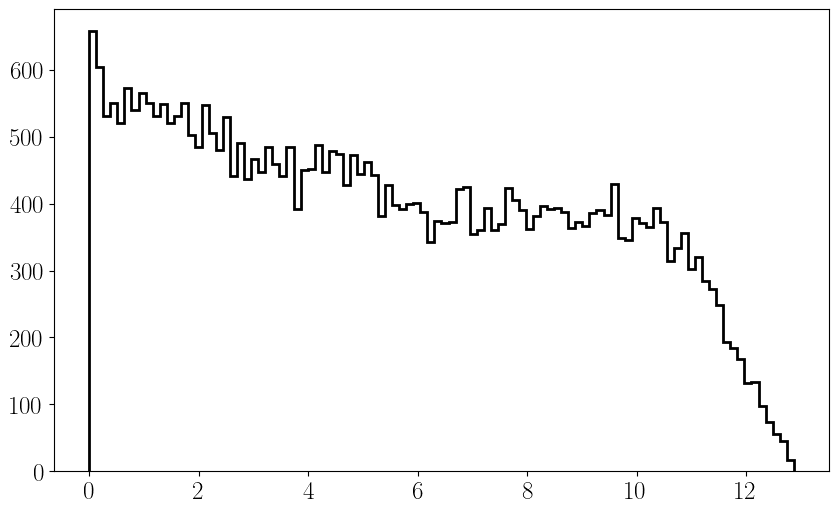

In [55]:
plt.figure(figsize=(10, 6))
plt.hist(pmage_catalog_with_photometry['age'], bins=100, histtype='step', lw=2, color='k')
plt.show()

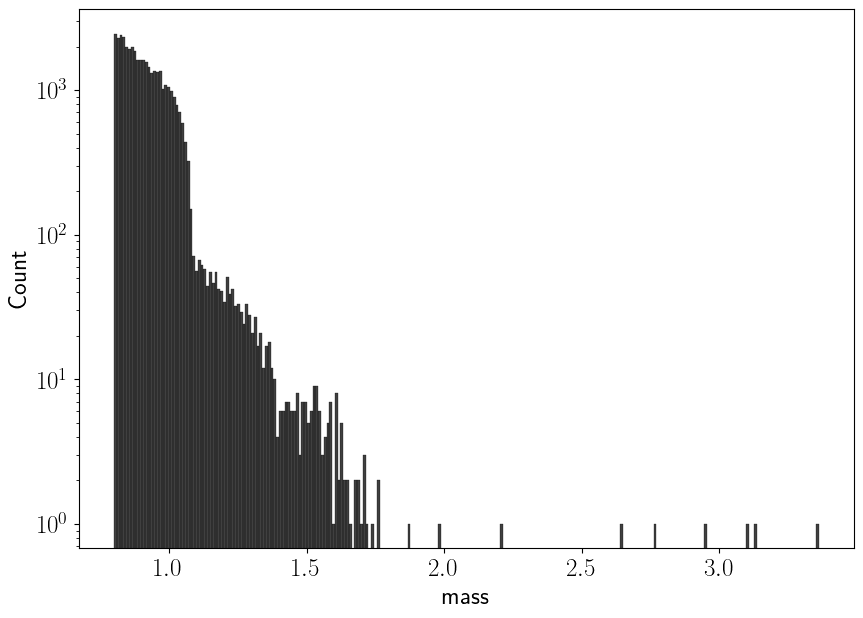

In [56]:
sns.histplot(data = pmage_catalog_with_photometry, x = 'mass', bins='scott', color='k')
plt.yscale('log')
plt.show()

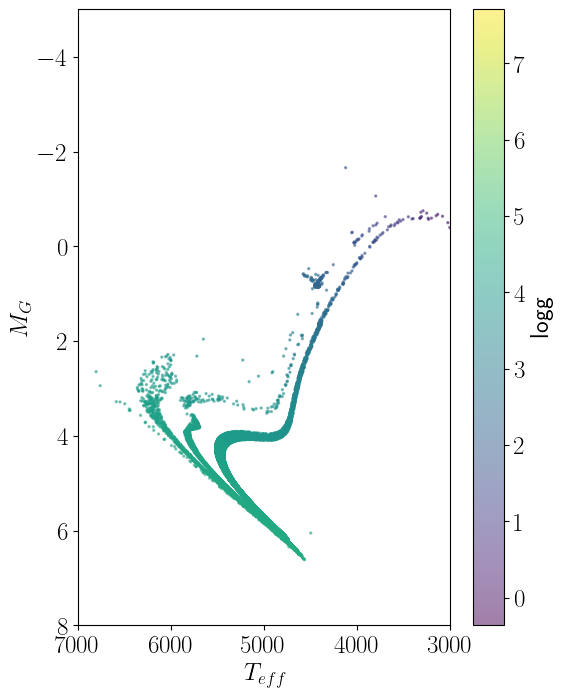

In [57]:
plt.figure(figsize=( 6, 8))
#sns.scatterplot(data=pmage_catalog_with_photometry, x='Teff', y='G', hue='eep' , alpha=0.5)
plt.scatter(pmage_catalog_with_photometry['Teff'], pmage_catalog_with_photometry['G'],
             c=pmage_catalog_with_photometry['logg'], cmap='viridis', alpha=0.5, s = 2)
plt.colorbar(label='logg')
plt.xlim(7000, 3000)
plt.ylim(8, -5)
plt.xlabel('$T_{eff}$')
plt.ylabel('$M_G$')
plt.savefig(os.path.join(plots_path, 'Teff_vs_G_NSC.png'), dpi=300)

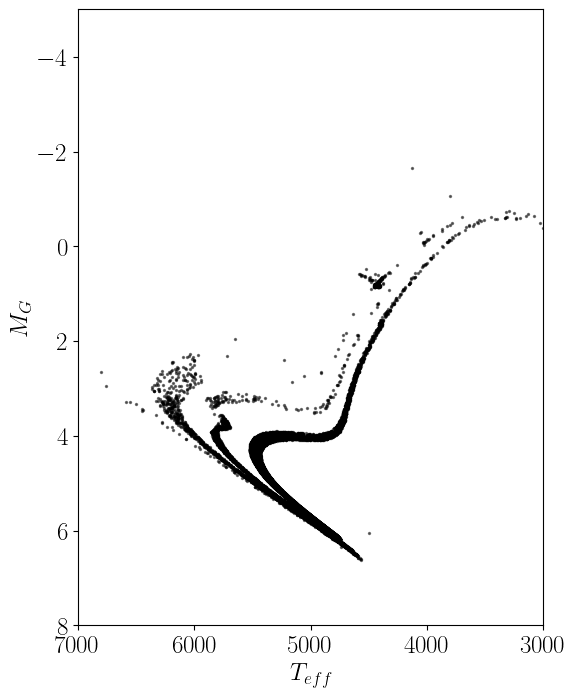

In [58]:
plt.figure(figsize=( 6, 8))
#sns.scatterplot(data=pmage_catalog_with_photometry, x='Teff', y='G', hue='eep' , alpha=0.5)
plt.scatter(pmage_catalog_with_photometry['Teff'], pmage_catalog_with_photometry['G'],
            c = 'k', alpha=0.5, s = 2)
plt.xlim(7000, 3000)
plt.ylim(8, -5)
plt.xlabel('$T_{eff}$')
plt.ylabel('$M_G$')
plt.savefig(os.path.join(plots_path, 'Teff_vs_G_NSC_nobar.png'), dpi=300)

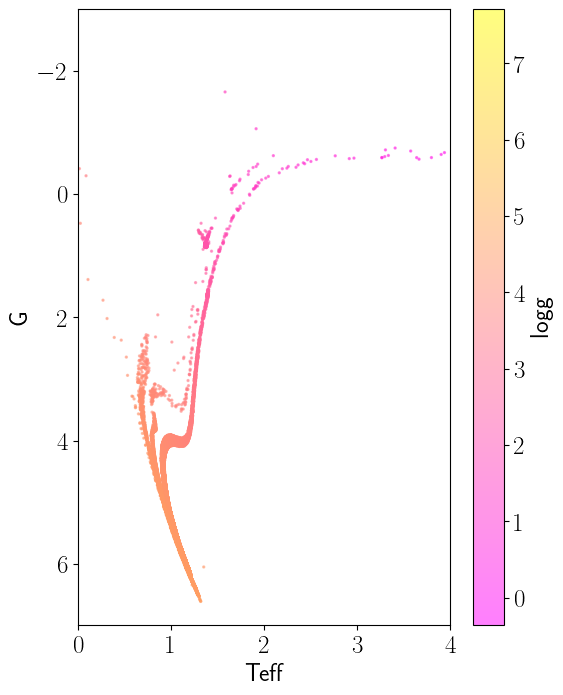

In [59]:
plt.figure(figsize=( 6, 8))
#sns.scatterplot(data=pmage_catalog_with_photometry, x='Teff', y='G', hue='eep' , alpha=0.5)
plt.scatter(pmage_catalog_with_photometry['BP'] -pmage_catalog_with_photometry['RP'] , pmage_catalog_with_photometry['G'],
             c=pmage_catalog_with_photometry['logg'], cmap='spring', alpha=0.5, s = 2)
plt.colorbar(label='logg')
plt.xlim(0, 4)
plt.ylim(7, -3)
plt.xlabel('Teff')
plt.ylabel('G')
plt.savefig(os.path.join(plots_path, 'CMD_NSC.png'), dpi=300)

## Turn into  training catalog

In [60]:
# merge with a large gaia catalog
data_gaia_big = pd.read_feather('/Users/mncavieres/Documents/2024-2/HVS/Data/Gaia_tests/200pc/raw_gaia_catalog/3M_sources_goodruwe.feather')
data_gaia_big['bp_rp'] = data_gaia_big['phot_bp_mean_mag'] - data_gaia_big['phot_rp_mean_mag']
data_gaia_big = data_gaia_big.dropna(subset=['bp_rp', 'phot_g_mean_mag'])

# subsample the gaia catalog
data_gaia = data_gaia_big.sample(50000)

# Add the path to the 'scripts' folder directly
sys.path.append('/Users/mncavieres/Documents/2024-2/HVS')



### Run implied distance and $V_r$ calculations on Gaia data

In [61]:

# Now you can import from the 'scripts' package
from scripts.implied_d_vr import *  # Or import any other module
from scripts.selections import *

In [62]:
data_gaia_big = implied_calculations(data_gaia_big)

In [63]:
# keep only positive implied parallaxes
data_gaia_big = data_gaia_big.loc[data_gaia_big['implied_parallax'] > 0]

In [64]:
# add extinction correction
data_gaia_big = extinction_correction(data_gaia_big)

In [65]:
# compute the implied absolute magnitude
data_gaia_big['implied_M_g'] = data_gaia_big['phot_g_mean_mag'] - 5*np.log10(1000/data_gaia_big['implied_parallax']) + 5
data_gaia_big['implied_M_g_corr'] = data_gaia_big['phot_g_mean_mag'] - 5*np.log10(1000/data_gaia_big['implied_parallax']) + 5

# set all gaia stars as not hvs
data_gaia_big['is_hvs'] = 0

In [66]:
# now add the simulated cmd
# keep in mind that the simulated photometry should be called implied_M_g_corr and bp_rp_corr
simulated_catalog = Table()
simulated_catalog['bp_rp_corr'] = pmage_catalog_with_photometry['BP'] - pmage_catalog_with_photometry['RP']
simulated_catalog['implied_M_g_corr'] = pmage_catalog_with_photometry['G']
simulated_catalog['phot_g_mean_mag'] = pmage_catalog_with_photometry['G']
simulated_catalog['phot_bp_mean_mag'] = pmage_catalog_with_photometry['BP']
simulated_catalog['phot_rp_mean_mag'] = pmage_catalog_with_photometry['RP']
simulated_catalog['is_hvs'] = 1

# add some scatter in bp_rp_corr and implied_M_g_corr
simulated_catalog['bp_rp_corr'] += np.random.normal(0, 0.03, len(simulated_catalog))
simulated_catalog['implied_M_g_corr'] += np.random.normal(0, 0.003, len(simulated_catalog))


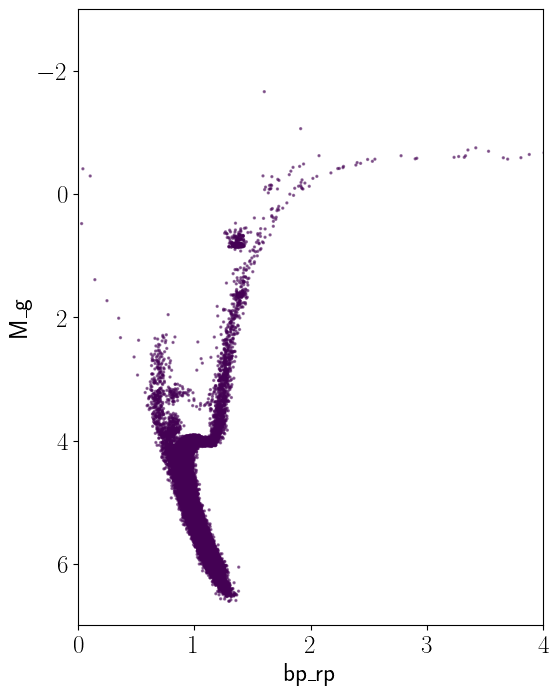

In [67]:
# plot the simulated cmd
plt.figure(figsize=( 6, 8))
plt.scatter(simulated_catalog['bp_rp_corr'], simulated_catalog['implied_M_g_corr'], c = simulated_catalog['is_hvs'], alpha=0.5, s = 2)
plt.xlim(0, 4)
plt.ylim(7, -3)
plt.xlabel('bp_rp')
plt.ylabel('M_g')
plt.show()

In [68]:
# create an astropy table with just the required columns from the gaia data
data_gaia_training = Table.from_pandas(data_gaia_big[['bp_rp', 'implied_M_g_corr', 'bp_rp_corr', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'is_hvs']])

In [69]:
# merge the pandas dataframes
training_catalog = vstack([data_gaia_training, simulated_catalog])

In [70]:
training_catalog.write('/Users/mncavieres/Documents/2024-2/HVS/Data/SFH_sampling_catalogs/training_catalog_CMD_classification/NSC_training_catalog_smaller.fits', overwrite=True)

## Test with simple populations

In [235]:
ages = np.linspace(0.1, 13, 1000)
mass = [1.0] * len(ages)
feh = [0.0] * len(ages)

In [236]:
get_star_photometry_v2

<function __main__.get_star_photometry_v2(feh_array, initial_mass_array, age_ejection_array, flight_time_array)>

In [237]:
testing_evol_track = get_star_photometry_v2(feh, mass, ages, [0]*len(ages))

Error during model generation for star with mass 1.0, age 10.079854554123724, feh 0.0: EEP minimization not successful: (1.0, 10.079854554123724, 0.0)
Error during model generation for star with mass 1.0, age 10.080320913570734, feh 0.0: EEP minimization not successful: (1.0, 10.080320913570734, 0.0)
Error during model generation for star with mass 1.0, age 10.080786772763043, feh 0.0: EEP minimization not successful: (1.0, 10.080786772763043, 0.0)
Error during model generation for star with mass 1.0, age 10.081252132772729, feh 0.0: EEP minimization not successful: (1.0, 10.081252132772729, 0.0)
Error during model generation for star with mass 1.0, age 10.081716994668424, feh 0.0: EEP minimization not successful: (1.0, 10.081716994668424, 0.0)
Error during model generation for star with mass 1.0, age 10.082181359515337, feh 0.0: EEP minimization not successful: (1.0, 10.082181359515337, 0.0)
Error during model generation for star with mass 1.0, age 10.082645228375261, feh 0.0: EEP min

In [238]:
testing_evol_track = testing_evol_track.to_pandas().dropna()

(8.0, -5.0)

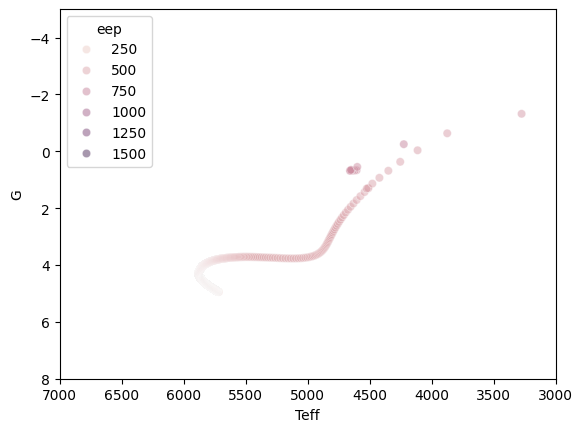

In [242]:
sns.scatterplot(data=testing_evol_track, x='Teff', y='G', hue='eep' , alpha=0.5)
plt.xlim(7000, 3000)
plt.ylim(8, -5)